In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import warnings
warnings.filterwarnings("ignore")

import gc
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import segmentation_models_pytorch.utils.metrics
from torchmetrics.classification import JaccardIndex
from albumentations.pytorch.transforms import ToTensorV2

In [2]:
DATA_DIR = './tiff/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')
print(x_train_dir)

def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x


./tiff/train


In [3]:
_transform = album.Compose([
        ToTensorV2()])
class Dataset(BaseDataset):

    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = []
        self.mask_paths = []
        for image_id in os.listdir(images_dir):
            self.image_paths.append (os.path.join(images_dir, image_id)) 
            self.mask_paths.append(os.path.join(masks_dir, image_id[:-1]) )
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        
        image = cv2.imread(self.image_paths[i], cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[i], cv2.COLOR_BGR2GRAY)
        # if self.transform:
        #     transformed = self.transform(image = image, mask = mask)
        #     image = transformed['image']
        #     mask  = transformed['mask']
        #     print(mask.shape)
        # mask = [(mask == v) for v in [0,255]]
        # mask = np.stack(mask, axis=-1).astype('float')
    


        # print(mask.shape)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        # print(mask.shape)
        
        new_mask = np.zeros((2, mask.shape[0], mask.shape[1]))
        new_mask[0] = np.where(mask == 255, 0, 1)
        new_mask[1] = np.where(mask == 0, 0, 1)
        # print(new_mask.shape)
        
        return image, new_mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

In [4]:
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

In [5]:
class_dict = pd.read_csv("./label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()
print(class_names)
print(class_rgb_values)

['background', 'road']
[[0, 0, 0], [255, 255, 255]]


In [6]:
# dataset = Dataset(x_train_dir, y_train_dir, class_rgb_values=class_rgb_values)
# random_idx = random.randint(0, len(dataset)-1)
# image, mask = dataset[random_idx] # get some sample
# def image_shower(images, labels, phase = None, predict = None, n=4):

#     for _ in range(n):

#         if phase == 'test' and predict:
#             fig, axes = plt.subplots(1, 3)
#         else:
#             fig, axes = plt.subplots(1, 2)
#         fig.set_figwidth(12) 
#         fig.set_figheight(6)
#         print(labels.shape)
#         print(images[0][0])
#         # if labels
#         # for i, image in enumerate(images[:n]):
#         axes[0].imshow(images[_].numpy().transpose((1, 2, 0)).squeeze())
#         axes[0].set_title('IMAGE')
#         axes[1].imshow(labels[_][1].numpy().squeeze())
#         axes[1].set_title('MASK')
#         if predict:
#             axes[2].imshow(labels[_].numpy().transpose((1, 2, 0)).squeeze())
#             axes[2].set_title('PREDICT_MASK')
#     plt.show()


#     image, mask = dataset[:4]
#     # visualize(image=image, mask=reverse_one_hot(mask))
#     # images, labels = next(iter(dataset[1]))
#     # print(image.shape)
#     # print(mask.shape)

#     # image_shower( image, mask , n=1)
# visualize(
#     image=image, 
#     mask= reverse_one_hot(mask),
# )





In [7]:
# def get_training_augmentation():
#     train_transform = [    
#         album.RandomCrop(height=256, width=256, always_apply=True),
#         album.OneOf(
#             [
#                 album.HorizontalFlip(p=1),
#                 album.VerticalFlip(p=1),
#                 album.RandomRotate90(p=1),
#             ],
#             p=0.75,
#         ),
#     ]
#     return album.Compose(train_transform)

# def get_validation_augmentation():
#     """Add paddings to make image shape divisible by 32"""
#     test_transform = [
#         album.Resize(224,224),
#     ]
#     return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    _transform = [
        album.Lambda(image=preprocessing_fn),
        # album.Lambda(image=ToTensorV2(), mask=ToTensorV2()),
        ToTensorV2(),
    ]
    return album.Compose(_transform)
get_augmentation = {
    'train':
        album.Compose([
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),]),
    'valid':
        album.Compose([
        album.Resize(224,224),
        ]),
}

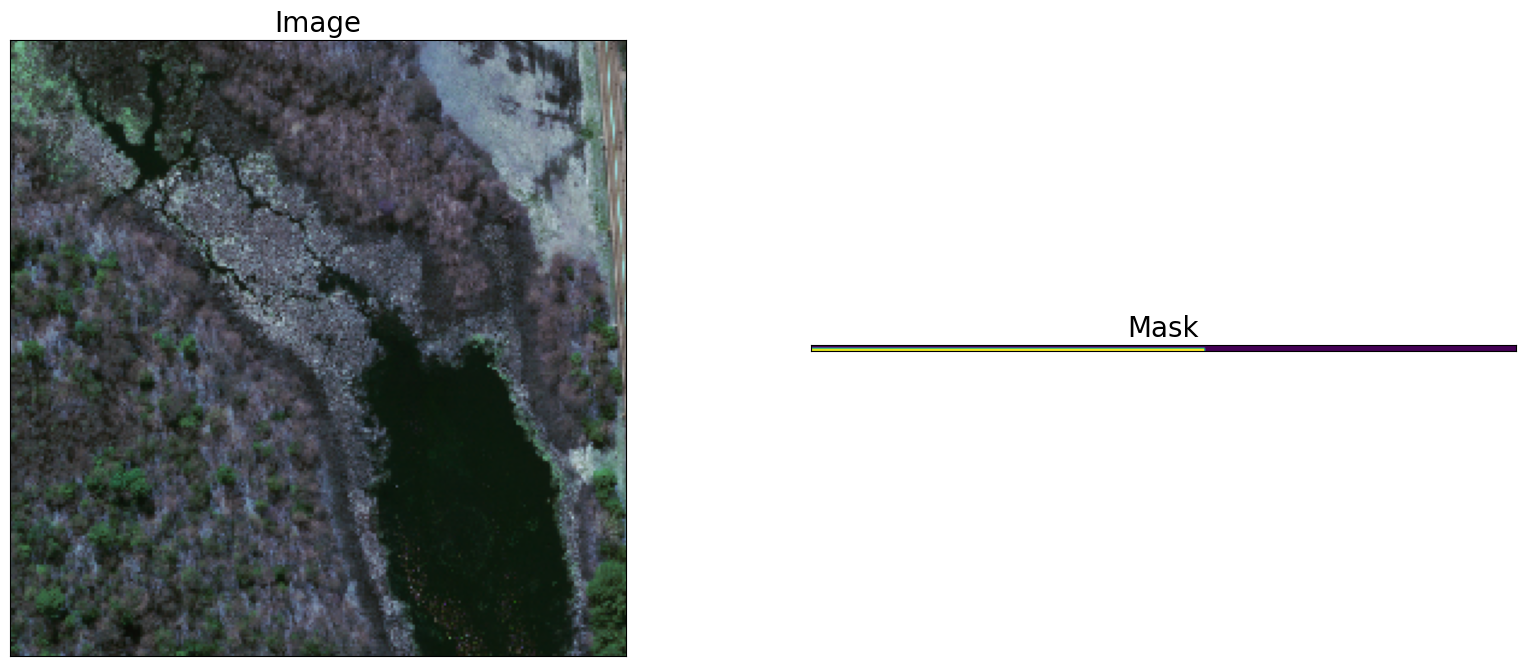

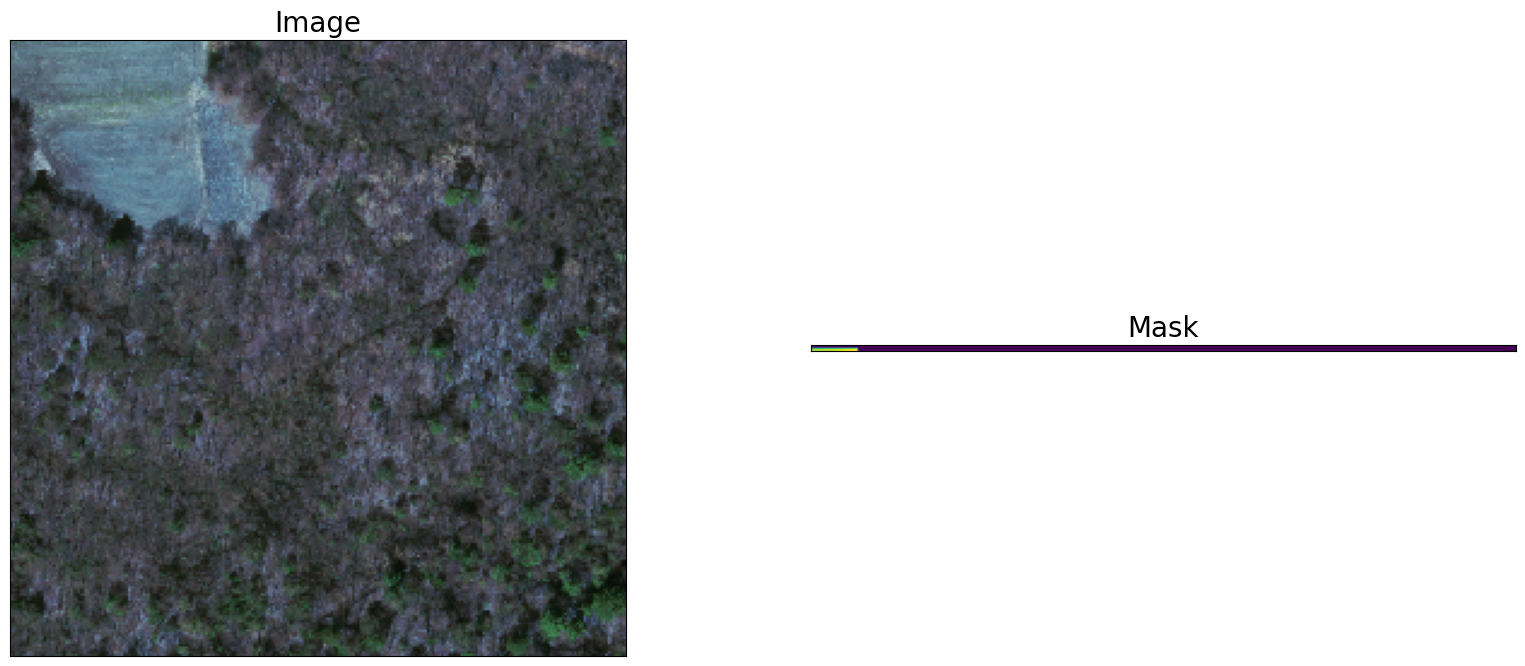

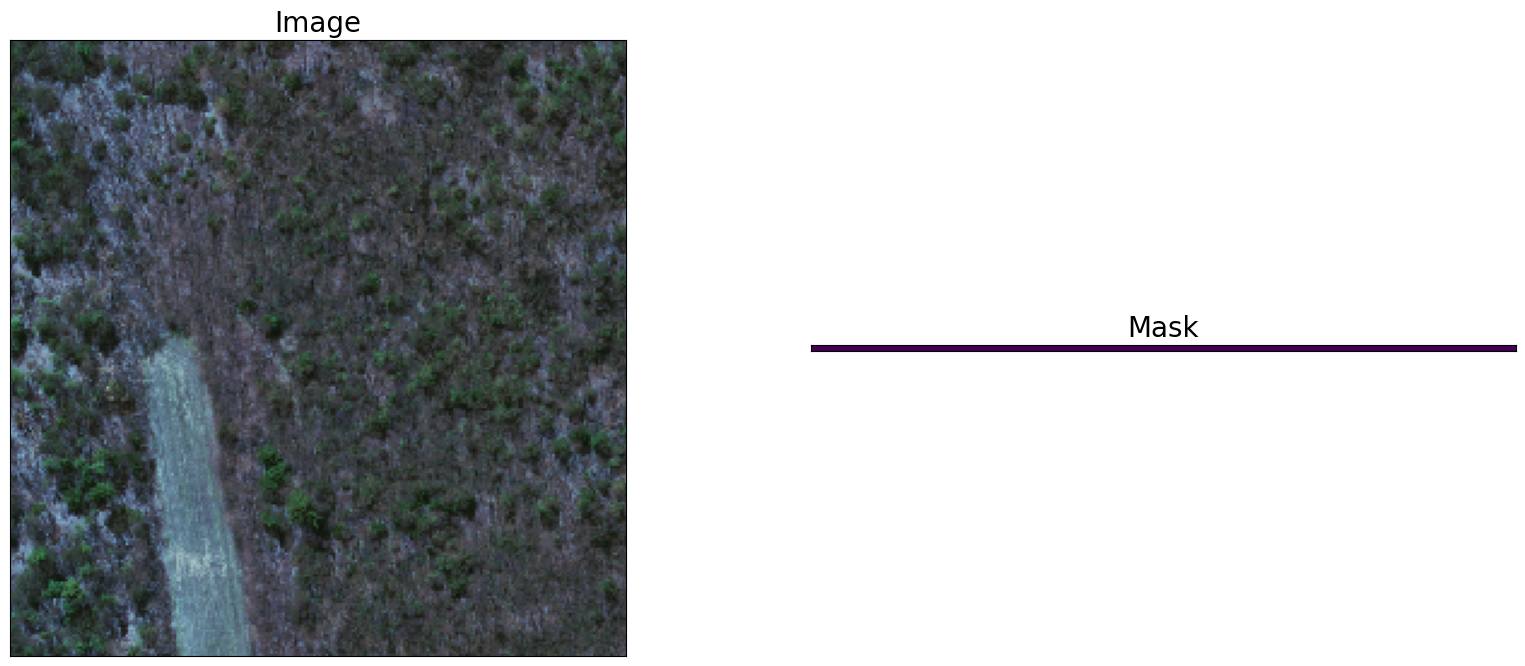

In [8]:
augmented_dataset = Dataset(
    x_train_dir, y_train_dir,
    augmentation=get_augmentation['train'], 
    class_rgb_values=class_rgb_values,
)
# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=reverse_one_hot(mask))

In [9]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 1
# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
model.to(DEVICE)
print(DEVICE)

cuda


In [10]:
data_image = {
    'train':
        Dataset(x_train_dir, y_train_dir, augmentation=get_augmentation['train'],preprocessing=get_preprocessing(preprocessing_fn), class_rgb_values=class_rgb_values,),
    'validation':
        Dataset(x_test_dir, y_test_dir, augmentation=get_augmentation['valid'], preprocessing=get_preprocessing(preprocessing_fn), class_rgb_values=class_rgb_values,),
    'test':
        Dataset(x_test_dir, y_test_dir,augmentation=get_augmentation['valid'], preprocessing=get_preprocessing(preprocessing_fn), class_rgb_values=class_rgb_values,),

}

loaders_image = {
    'train':
        DataLoader(data_image['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=0),
    'validation':
        DataLoader(data_image['validation'], batch_size=BATCH_SIZE, shuffle=True, num_workers=0),
    'test':
        DataLoader(data_image['test'], batch_size=BATCH_SIZE, shuffle=True, num_workers=0),
}
# augmented_dataset = Dataset(
#     x_train_dir, y_train_dir,
#     augmentation=get_augmentation['train'], 
#     class_rgb_values=class_rgb_values,
# )
# same image with different random transforms
# for i in range(3):
#     image, mask = augmented_dataset[1]
#     visualize(image=image, mask=reverse_one_hot(mask))
# for i in range(3):
#     image, mask = data_image['train'][1]
#     visualize(image=image, mask=reverse_one_hot(mask))
def image_shower(images, labels, phase = None, predict = None, n=4):

    for _ in range(n):

        if phase == 'test' and predict:
            fig, axes = plt.subplots(1, 3)
        else:
            fig, axes = plt.subplots(1, 2)
        fig.set_figwidth(12) 
        fig.set_figheight(6)
        # print(labels[_][0].numpy().shape)
        # print(images.shape)
        # # if labels
        # for i, image in enumerate(images[:n]):
        axes[0].imshow(images[_].numpy().transpose((1, 2, 0)).squeeze())
        axes[0].set_title('IMAGE')
        axes[1].imshow(labels[_][1].numpy().squeeze())
        axes[1].set_title('MASK')
        if predict:
            axes[2].imshow(labels[_].numpy().transpose((1, 2, 0)).squeeze())
            axes[2].set_title('PREDICT_MASK')
    plt.show()


# images, labels = next(iter(loaders_image['test']))
# image_shower( images, labels)

In [11]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss().to(DEVICE)
# metrics = [smp.utils.metrics.IoU(threshold=0.5),]
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0001)
# optimizer = torch.optim.Adam([ dict(params=model.parameters(), lr=0.0001),])

In [12]:
train_losses = []
valid_losses = []
ioys_score = np.zeros(20)
def train_model(model, criterion, optimizer, num_epochs=20):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        metric = JaccardIndex(task = 'binary', average = 'macro').to(DEVICE)
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in loaders_image[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(inputs.float())
                loss = criterion(outputs, labels.float())

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                tp, fp, fn, tn = smp.metrics.get_stats(outputs,labels.int(), mode='binary', threshold=0.5)
                running_loss += loss.item() * inputs.size(0)
                # metric.update(outputs, labels)
                # running_corrects += torch.sum(preds == labels.data)
                running_corrects += sum(smp.metrics.iou_score(tp, fp, fn, tn))
            print('WOW')
            epoch_loss = running_loss / len(data_image[phase])
            # epoch_iou = metric.compute() * 100
            epoch_iou = running_corrects / len(data_image[phase]) * 100
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                valid_losses.append(epoch_loss)
                if best_acc < epoch_iou: 
                    best_acc = epoch_iou
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model, './best_model.pth')
            # print('{} loss: {:.4f}, epoch_iou: {:.4f}'.format(phase,
            #                                             epoch_loss,
            #                                             epoch_iou))
            print("Loss : ", epoch_loss)
            print("epoch_iou : ", epoch_iou)
            
    return model.load_state_dict(best_model_wts)

train_model(model, criterion, optimizer)
fig = plt.figure(figsize=(10, 10))

plt.plot(train_losses[1:], label='train')
plt.plot(valid_losses[1:], label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')

Epoch 1/20
----------
WOW
Loss :  0.5589052333298142
epoch_iou :  tensor([93.8986,  4.3203], device='cuda:0')
WOW


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
# max_score = 0

# for i in range(0, 10):
    
#     print('\nEpoch: {}'.format(i))
#     train_logs = train_epoch.run(train_loader)
#     valid_logs = valid_epoch.run(valid_loader)
    
#     # do something (save model, change lr, etc.)
#     if max_score < valid_logs['iou_score']:
#         max_score = valid_logs['iou_score']
#         torch.save(model, './best_model.pth')
#         print('Model saved!')
        
#     if i == 25:
#         optimizer.param_groups[0]['lr'] = 1e-5
#         print('Decrease decoder learning rate to 1e-5!')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


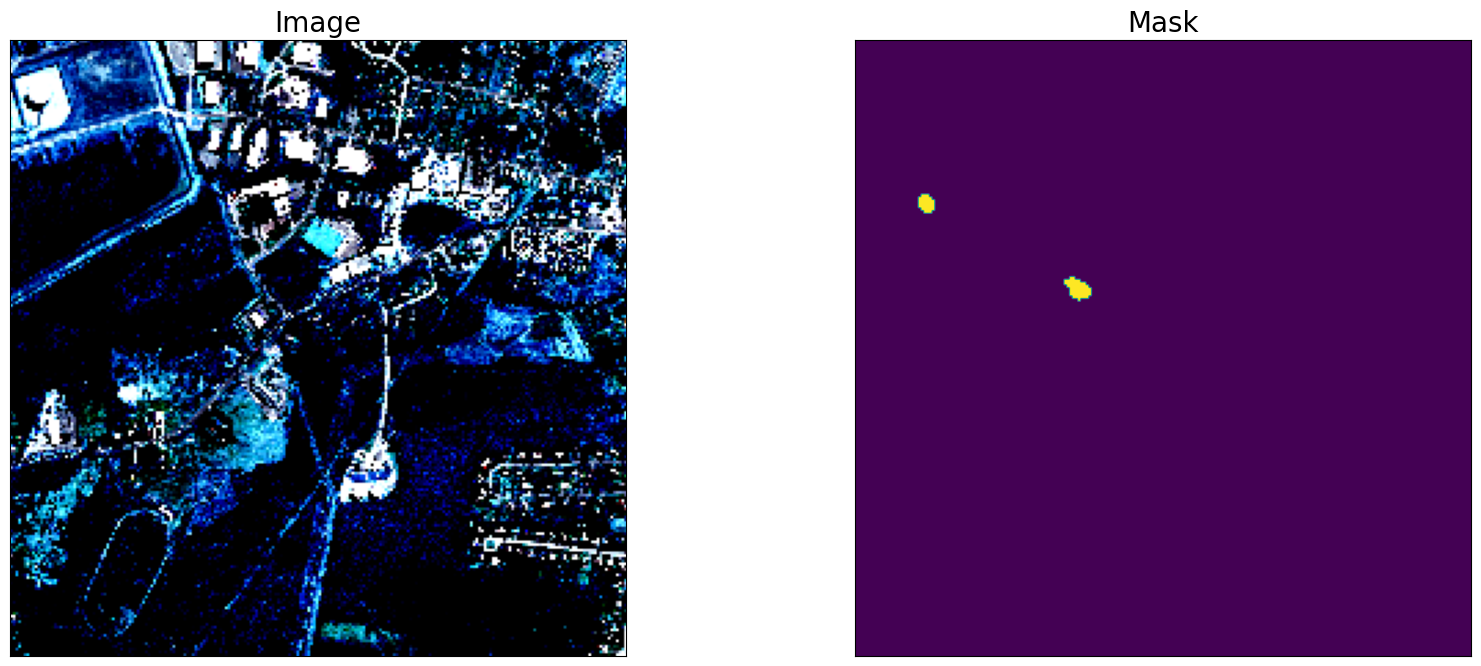

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
F1-score of the network on the 49 validation images: 90.5893 %


In [ ]:
metric = JaccardIndex(task = 'binary', average = 'macro').to(DEVICE)

with torch.no_grad():

    total = 0
    all_labels = []
    all_predicts = []

    for i, (images, labels) in enumerate(loaders_image['test']):
        
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        print(images[0].shape)
        outputs = model(images)
        total += labels.size(0)

        if not i:
            visualize(image=images[0].cpu().numpy().transpose(2,1,0), mask=reverse_one_hot(outputs[0].cpu().numpy().transpose(1,2,0)))
        # for a, res in enumerate(predicted):
        #     if classes_image['train'][res] == classes_image['test'][labels[a]]:
        #        predicted[a] = labels[a]

        # all_labels = np.concatenate((all_labels, labels.cpu()), axis = 0)
        # all_predicts = np.concatenate((all_predicts, predicted.cpu()), axis = 0)
        metric.update(outputs,labels)
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    # print('Accuracy of the network on the {} validation images: {:.4f} %'.format(total, 100 * accuracy_score(all_labels, all_predicts)))
    # print('Precision of the network on the {} validation images: {:.4f} %'.format(total, 100 * precision_score(all_labels, all_predicts, average = 'weighted', zero_division = 0)))
    # print('Recall of the network on the {} validation images: {:.4f} %'.format(total, 100 * recall_score(all_labels, all_predicts, average = 'weighted', zero_division = 0)))
    print('F1-score of the network on the {} validation images: {:.4f} %'.format(total, 100 * metric.compute()))